Naive Bayes Algorithm-Granularity Classifier

We will use AIPS platform to distinguish between peroxisome-positive and peroxisome-negative cells by imaging GFP-expressing Catalse. To model peroxisomes, we will use Pex13 mutant cells, with GFP-cat signal spread throughout the cytoplasm.

The ```AIPS_cellpose``` module is used for segmenting input image cytoplasmic signal. 
```python
from AIPyS.AIPS_cellpose import granularityMesure_cellpose
```
Segment cells and measure area of each cell which is marked in red. In the cellular level, granularity will be analysed.   
```python

wt, WTtable, WTdf = granularityMesure_cellpose(file = fileNmae[1],path = path, classLabel = 0,
                               outPath = None, clean = None, outputTableName = None,saveMode=False,intensity = 1)

kO, kOtable, kOdf = granularityMesure_cellpose(file = fileNmae[0],path = path, classLabel = 0,
                               outPath = None, clean = None, outputTableName = None,saveMode=False, intensity = 1)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(wt, cmap=plt.cm.gray)
ax[0].title.set_text('WT')
ax[1].imshow(ko, cmap=plt.cm.gray)
ax[1].title.set_text('PEX3KO')

```


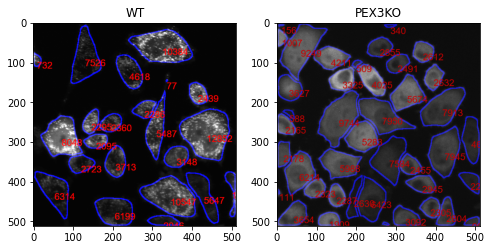

In [59]:
# {code-cell} ipython3
# :tags: [hide-input]

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import tifffile as tfi
import numpy as np
from PIL import Image
from skimage.filters import threshold_local
from scipy.ndimage.morphology import binary_opening
from skimage import io, filters, measure, color, img_as_ubyte
import skimage.morphology as sm
from skimage.segmentation import watershed
from skimage import measure
from skimage.exposure import rescale_intensity
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageEnhance
from skimage import io
import sys
sys.path.append(r'F:\Gil\AIPS_platforms\AIPyS')
from AIPyS import AIPS_file_display as afd
from AIPyS import AIPS_cellpose as AC
from AIPyS.AIPS_cellpose import granularityMesure_cellpose

fileNmae = ['PEX3KO.tif','WT.tif']
path = '/data/kanferg/Images/Pex_project/SIngle_cell_images_training_set/AIPyS_Images'
path = r'F:\Gil\AIPS_platforms\AIPyS\data'
WTcompsiteImage, WTtable, WTdf, WTgTable = granularityMesure_cellpose(file = fileNmae[1],path = path, classLabel = 0,outPath = None, clean = None, outputTableName = None,saveMode=False,intensity = 1,start_kernel=2, end_karnel=60, kernel_size=10)
kOcompsiteImage, kOtable, kOdf, kOgTable = granularityMesure_cellpose(file = fileNmae[0],path = path, classLabel = 1,outPath = None, clean = None, outputTableName = None,saveMode=False, intensity = 1,start_kernel=2, end_karnel=60, kernel_size=10)
# PEX3KO = io.imread(os.path.join(path,fileNmae[0]))
# WT = io.imread(os.path.join(path,fileNmae[1]))
# adjust the brightness
WT = ImageEnhance.Brightness(WTcompsiteImage)
WT_dimmer = WT.enhance(2)
PEX = ImageEnhance.Brightness(kOcompsiteImage)
Pex_dimmer = PEX.enhance(0.8)
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(WT_dimmer, cmap=plt.cm.gray)
ax[0].title.set_text('WT')
ax[1].imshow(Pex_dimmer, cmap=plt.cm.gray)
ax[1].title.set_text('PEX3KO')

The method of analysis of granularity examines the effect of openings of increasing size on images of differing granularity. The volume of the open image is calculated as the sum of all pixels in each step, and the difference in volume between these successive steps is the granular spectrum. This granular spectrum is then normalized to the total volume (integrated intensity) of the image in order to create a diagram that displays how the different sizes of opening affect the images. Phenotype are assigned for training the model. For example, **1** for Pex3-KO and **0** for the WT cells. </Br>
Marge Granularity Table from both classes and plot Granularity spectrum. 


In [60]:
# {code-cell} ipython3
# :tags: [hide-input]

WTdf["classLabel"] = int(0)
kOdf["classLabel"] = int(1)
dfGranSpect=pd.concat((WTdf, kOdf))

df = dfGranSpect.reset_index() # Make the index unique 
styles = [{'selector': 'th', 'props': [('font-size', '8px'), ('max-width', '50px')]}, 
           {'selector': 'td', 'props': [('font-size', '8px'), ('max-width', '50px')]}]

df.style.set_table_styles(styles)


,index,kernel,Signal intensity (ratio),classLabel
0,0,0,1.000000,0
1,1,2,0.890134,0
2,2,8,0.656016,0
3,3,14,0.513061,0
4,4,21,0.381961,0
5,5,27,0.282762,0
6,6,34,0.221506,0
7,7,40,0.190235,0
8,8,47,0.157380,0
9,9,53,0.139901,0


In [61]:
# {code-cell} ipython3
# :tags: [hide-input]

list_of_integers = np.arange(0,22,1,'int').tolist()
test = kOgTable[kOgTable['labeledCell'].isin(list_of_integers)]
vec = np.repeat(np.arange(22,44,1,'int'),11).tolist()
test.loc[:,'labeledCell'] = vec
print('{} \n {}'.format(np.unique(test['labeledCell']), np.unique(WTgTable['labeledCell'])))
dfPerCell = pd.concat((WTgTable,test))

[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


Merging the granularity tables and ploting granularity spectrom over time:
    ```python
    GranPerCell = pd.concat((WTgTable,kOgTable))
    ```


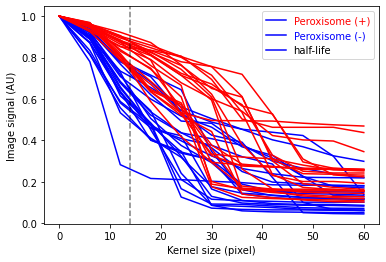

In [62]:
# {code-cell} ipython3
# :tags: [hide-input]

def get_cmap(n, name='hsv'): 

    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct  

    RGB color; the keyword argument name must be a standard mpl colormap name.''' 

    return plt.cm.get_cmap(name, n) 
un_names = np.unique(dfPerCell['labeledCell']) 
cmap = get_cmap(len(un_names)) 
fig = plt.figure() 
x = np.linspace(0,60,11,dtype='int').tolist()
ax = fig.add_subplot(1, 1, 1) 
for i,un_name in enumerate(un_names): 
    teble_temp = dfPerCell.loc[lambda x: (x['labeledCell'] == un_name),:]
    teble_temp = teble_temp.sort_values(by='kernel')
    y = teble_temp.intensity.tolist() 
    if teble_temp['classLabel'].values[0] == 1:
        ax.plot(x, y, color='r')
    else:
        ax.plot(x, y, color='b')
ax.set_ylabel('Image signal (AU)')
ax.set_xlabel('Kernel size (pixel)')
ax.legend(['Peroxisome (+)','Peroxisome (-)', 'half-life'],labelcolor = ('r','b','k'))
ax.axvline(x=14, color = 'k', linestyle = '--',alpha = 0.5)

Maximum separation on kernel 13, with a vertical dashed line.

<center><b><u>A peroxisome logistic regression classifier</u></b></center>

A peroxisome logistic regression classifier is a machine learning algorithm that is used to classify items based on their peroxisomal characteristics. This type of classifier can help identify items that are likely to be located within a peroxisome, as well as help to identify potential biomarkers for diseases associated with peroxisomal dysfunction. The classifier is trained on a dataset consisting of features associated with peroxisomes and then used to predict the presence or absence of a particular feature in an unknown sample. By training the classifier on a range of features, it is able to accurately predict the presence or absence of a feature in a given sample.

Here is the The logistic model used for classify peroxisome:

<div style="text-align:center">
$y|\alpha,\beta,b  \sim Bernoulli(\theta)$<br/>
$\theta = logistic(\alpha + \beta \times b)$ 
</div>


**The exponential decay equation** 

$ t = a \times t0 \times e^{-b \times kernel}$\

where t is the current value of the decaying quantity, t0 is the initial value of the decaying quantity, a is a constant, b is the decay rate and kernel is the time interval over which the decay takes place.

$b =  - \frac {ln \frac {t}{t0}}{Kernel}$

The decay rate, b, is calculated by taking the natural logarithm of the ratio of the current value to the initial value and dividing it by the kernel. 

**The Decay formula logistic model** is a mathematical expression used to model the behaviour of a system over time. It is based on the idea that the rate of change in the system is proportional to the current state of the system. The equation is represented as: 

$\theta = logistic(\alpha + \beta \frac {ln \frac {t}{t0}}{Kernel})$ 

Where: 

$\theta$ is the output of the model, which describes the rate of change in the system.

The Normal distribution prior assigned to $\alpha$ and $\beta$ had a mean of 0 and a standard deviation of 10, which can be adjusted to control the behavior of the model.

$t$ is the current state of the system.

$t0$ is the initial state of the system.

$Kernel$ is the rate of change in the system.

The logistic part of the equation is used to ensure that the output is within a certain range. This range is defined by the parameters $a$ and $\beta$. 

<center><b><u>Logistic Regression Classifier, training</u></b></center>

As demonstrated above, the ```granularityMesure_cellpose``` function performs a granularity analysis on the input image, producing a granularity table, e.g.

In [69]:
# {code-cell} ipython3
# :tags: [hide-input]

dfPerCell.head(2)

,labeledCell,kernel,intensity,classLabel
0,0,0,1.000000,0
1,0,2,0.816656,0


The data folder contains CSV files that have been generated by the ```granularityMesure_cellpose``` tool, which can be used to train a Bayes model.
Here, model is trained using 700 labeled single cells that have been segmented from 5 images. 

:::{note}
The Bayesian classifier requires two CSV files, one for class 0 (phenotype) and one for class 1 (wild type)
e.g. norm.csv, pheno.csv 
:::

```python
from AIPyS.Baysian_training import bayesModelTraining
pathIn =   'data'
files = glob.glob(pathname=pathIn+"\*.csv")
Table_MergeFinel, Table_MergeFinelFitelrd, rate, y_0, trace = bayesModelTraining(files = files,  kernelSize = 5, pathOut = None,reportFile = None)
```
Next, the similarities and differences between the classes are identified and evaluated. 

In [63]:
# {code-cell} ipython3
# :tags: [hide-input]

import sys
sys.path.append(r'F:\Gil\AIPS_platforms\AIPyS')
import glob
from AIPyS.Baysian_training import bayesModelTraining
import pandas as pd
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm
print(pm.__version__)
import os
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

3.11.5


In [64]:
# {code-cell} ipython3
# :tags: [hide-input]

pathIn =   r'F:\Gil\AIPS_platforms\AIPyS\data'
files = glob.glob(pathname=pathIn+"\*.csv")
dfMergeFinel, dfMergeFinelFitelrd, rate, y_0, trace = bayesModelTraining(files = files,kernelSize = 5,pathOut = None, reportFile = None)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 98 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [65]:
# {code-cell} ipython3
# :tags: [hide-input]

def classify(n, thold):
    mu = trace['a'].mean() + trace['b'].mean() * n
    prob = 1 / (1 + np.exp(-mu))
    return prob, prob > thold
td = 0.5
prob, prediction = classify(rate, td)
y_true = y_0
y_pred = np.where(prediction == True, 1, 0)
performance = precision_recall_fscore_support(y_true, y_pred, average='macro')


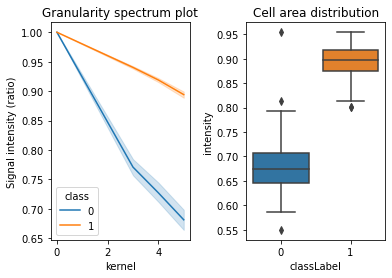

In [66]:
# {code-cell} ipython3
# :tags: [hide-input]

dfline = pd.DataFrame({"kernel": dfMergeFinel.kernel.values, "Signal intensity (ratio)": dfMergeFinel.intensity.values,
                         "class": dfMergeFinel.classLabel.values})
classLabel = dfMergeFinelFitelrd.classLabel.values.tolist()
intensity = dfMergeFinelFitelrd.intensity.values.tolist()
df = pd.DataFrame({"classLabel": classLabel, "intensity": intensity})
fig, ax = plt.subplots(1,2)
sns.lineplot(data=dfline, x="kernel", y="Signal intensity (ratio)", hue="class", ax= ax[0]).set(title='Granularity spectrum plot')
sns.boxplot(data=df, x="classLabel", y="intensity", ax = ax[1]).set(title='Cell area distribution')
fig.subplots_adjust(wspace= 0.4) 

The trace-plot in pymc3 is a graphical representation of the sampling results obtained from a MCMC algorithm. It plots the sampled values of the parameters over the iterations, allowing the user to assess the convergence of the algorithm, as well as the overall distribution of the samples. The trace-plot can also be used to identify potential divergences, which indicate that the MCMC algorithm may not have properly converged. The trace-plot can also be used to identify potential areas of improvement, such as increasing the number of samples or adjusting the step size of the chain.

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'bd'}>,
        <AxesSubplot:title={'center':'bd'}>]], dtype=object)

<Figure size 216x216 with 0 Axes>

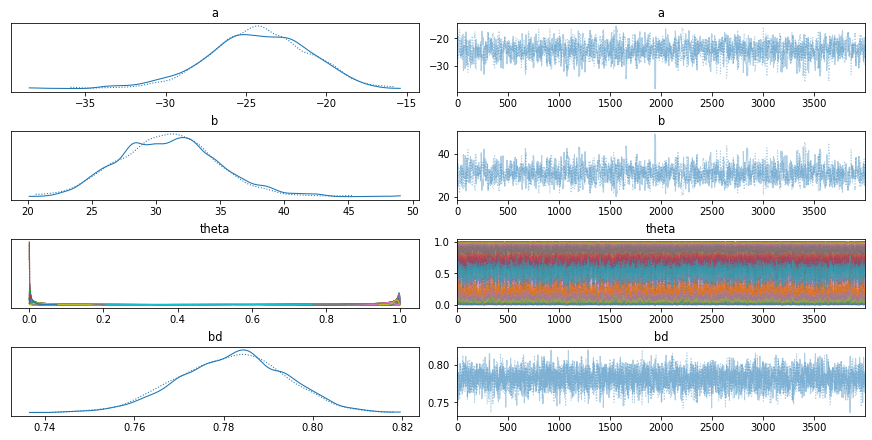

In [67]:
# {code-cell} ipython3
# :tags: [hide-input]

plt.figure(figsize=(3, 3))
az.plot_trace(trace, figsize=(12, 6), compact=True)

<b><u>Model evaluation </u></b>
The boundaries between classes are determined by the logistic function, which is used to calculate the probability of a data point belonging to a particular class. The model's parameters are estimated based on the training data, and the model is then used to make predictions on unseen data.

$\theta = logistic(\alpha + \beta \times b)$
<Br/>
<Br/>
$bd = - \frac{\alpha}{\beta}$

Text(0, 0.1, 'b :30.99')

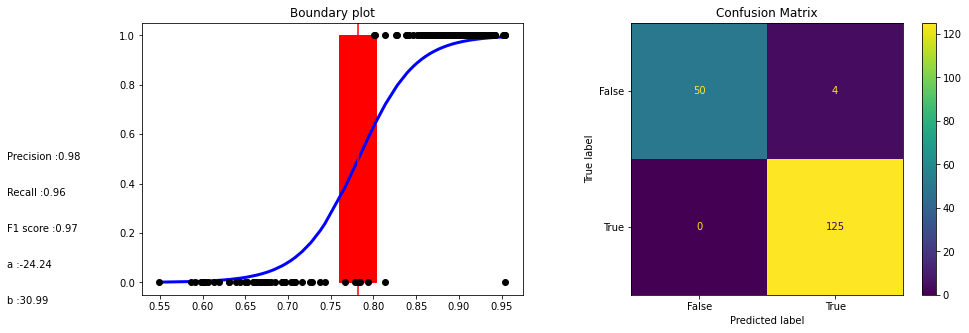

In [68]:
# {code-cell} ipython3
# :tags: [hide-input]

fig,ax = plt.subplots(1,2,figsize=(15, 5))
idx = np.argsort(rate)
theta = trace['theta'].mean(0)
ax[0].set_title('Boundary plot')
ax[0].plot(rate[idx], theta[idx], color='b', lw=3)
ax[0].axvline(trace['bd'].mean(), ymax=1, color='r')
bd_hdi = pm.hdi(trace['bd'])
ax[0].fill_betweenx([0, 1], bd_hdi[0], bd_hdi[1], color='r')
ax[0].plot(rate, y_0, 'o', color='k')

confusion_matrix = metrics.confusion_matrix(np.array(dfMergeFinelFitelrd.classLabel.values, dtype=int),np.where(prediction, 1, 0))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
cm_display.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix')
ax[1].text(0, 0.5, "Precision :{}".format(np.round(performance[0],2)), fontsize=10, transform=plt.gcf().transFigure)
ax[1].text(0, 0.4, "Recall :{}".format(np.round(performance[1],2)), fontsize=10, transform=plt.gcf().transFigure)
ax[1].text(0, 0.3, "F1 score :{}".format(np.round(performance[2],2)), fontsize=10, transform=plt.gcf().transFigure)
ax[1].text(0, 0.2, "a :{}".format(np.round(trace['a'].mean(), 2)), fontsize=10,transform=plt.gcf().transFigure)
ax[1].text(0, 0.1, "b :{}".format(np.round(trace['b'].mean(), 2)), fontsize=10,transform=plt.gcf().transFigure)